# 2D Annotations of Molecules 

## Introduction

## Dependencies

In [1]:
# import required libraries
from iodata import load_one, dump_one

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem 
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import rdMolTransforms 
from rdkit.Chem import PeriodicTable
from rdkit.Chem import rdmolfiles
from rdkit.Chem.Draw import DrawingOptions

from IPython.display import SVG
from IPython.display import Image

from collections import OrderedDict

from chemml.chem import Molecule

import pandas as pd

import glob
import os

## Manipulation of Input and Extraction of Charges 

In [2]:
inputName = 'dichloropyridine26_q+0.fchk'
xyzName = 'dichloropyridine26_q+0.xyz'
molName = xyzName[:-4]
print("Molecule Name : ")
print(molName)
print(" ")

loadInput = load_one(inputName) 
numbers = np.ndarray.tolist(loadInput.atnums)
chargeDict = (loadInput.atcharges)
print(chargeDict)
espCharges = (chargeDict['esp'][:])
print(espCharges)



Molecule Name : 
dichloropyridine26_q+0
 
{'mulliken': array([-0.17984029, -0.17984725,  0.05002824, -0.04091242,  2.02394948,
        2.0239583 , -0.86473324, -0.86474131, -0.67554864, -0.64615815,
       -0.64615473]), 'esp': array([-0.11982276, -0.11982857, -0.53824353,  0.26057369, -0.45320065,
       -0.4532028 ,  0.49976881,  0.49977265,  0.0844758 ,  0.16985231,
        0.16985503]), 'npa': array([ 0.01191899,  0.01191245, -0.49012581, -0.1689309 , -0.27573862,
       -0.2757388 ,  0.21524212,  0.21524428,  0.24472353,  0.25574567,
        0.25574709])}
[-0.11982276 -0.11982857 -0.53824353  0.26057369 -0.45320065 -0.4532028
  0.49976881  0.49977265  0.0844758   0.16985231  0.16985503]


## Manipualt

[<chemml.chem.Molecule(
        rdkit_molecule : <rdkit.Chem.rdchem.Mol object at 0x7fca34180760>,
        pybel_molecule : <openbabel.pybel.Molecule object at 0x7fca34177750>,
        creator        : ('XYZ', 'dichloropyridine26_q+0.xyz'),
        smiles         : 'Clc1cccc(Cl)n1',
        smarts         : None,
        inchi          : None,
        xyz            : <XYZ(geometry: (11, 3), atomic_numbers: (11, 1), atomic_symbols: (11, 1))>)>]
 

                         Name          SMILES
0  dichloropyridine26_q+0.xyz  Clc1cccc(Cl)n1
 
Our Molecule in SMILES format: 
Clc1cccc(Cl)n1
 


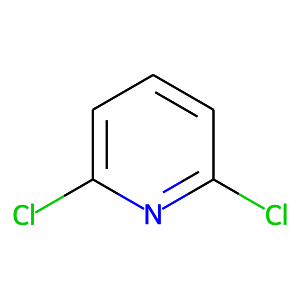

In [3]:
dump_one(loadInput,xyzName )
xyz_files = glob.glob(xyzName)

# make a list of ChemML Molecule object instances based on the names of the xyz files from xyz_files
molecule_list = [Molecule(xyzName, input_type='xyz') for file in xyz_files]

# alter the ChemML Molecule object instances of molecule_list so that their SMILES codes can be recognzied by RDKit
for molecule in molecule_list:
    molecule.to_smiles(kekuleSmiles=True)

print(molecule_list)

table = pd.DataFrame(data={'Name':xyzName,  
                         'SMILES':[molecule.smiles for molecule in molecule_list]}, 
                   columns=['Name','SMILES'])

print(" ")
print("")
print(table)

print(" ")
smiles = table.iloc[0,1]
print("Our Molecule in SMILES format: ")
print(smiles)
print(" ")

chem = Chem.MolFromSmiles(smiles)
chemc = Chem.Mol(chem.ToBinary())

drawMolecule = rdMolDraw2D.MolDraw2DCairo(300, 300)
rdMolDraw2D.PrepareAndDrawMolecule(drawMolecule, chemc)
drawMolecule.drawOptions().addStereoAnnotation = True
#drawMolecule.drawOptions().addAtomIndices = True
#drawMolecule.drawOptions().addBondIndices = True
drawMolecule.DrawMolecule(chemc)
drawMolecule.FinishDrawing()
png = drawMolecule.WriteDrawingText('molecule.png')
png

Image(filename="molecule.png")




[17, 17, 7, 6, 6, 6, 6, 6, 1, 1, 1]

[-0.11982276 -0.11982857 -0.53824353  0.26057369 -0.45320065 -0.4532028
  0.49976881  0.49977265  0.0844758   0.16985231  0.16985503]
test
7


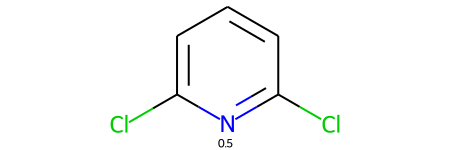

In [9]:
chem2 = Chem.MolFromSmiles(smiles)
#listChargesESP = np.ndarray.tolist(espCharges)
        
print(numbers)
print()
print(espCharges)

for i, atom in enumerate(chem2.GetAtoms()):
   #atom.SetProp("atomNote",f"{espCharges[i]}")
    if atom.GetAtomicNum() == 7:
        print('test')
        print(atom.GetAtomicNum())
        atom.SetProp("atomNote", f"{np.round(float(espCharges[i]),3)}")    
chem2




In [ ]:
'''

for item in loadInput.atcharges["esp"]:
    key = loadInput.atnums
    listCharge = item
    print(listCharge)
    
for number in loadInput.atnums: 
    print(number)
    

q = pd.DataFrame.from_dict(loadInput.atcharges.items())
print("Atomic Charges : ")
print(q)
print(" ")

espCharges = q.iloc[1,1]
print("Charges, ESP : ")
print(espCharges)
print(" ")

atomicNumbers = loadInput.atnums
print("Atomic Numbers : ")
print(atomicNumbers)
'''

'''
listAtomicNumbers = np.ndarray.tolist(atomicNumbers)
print(listAtomicNumbers)

listChargesESP = np.ndarray.tolist(espCharges)
print(listChargesESP)

atomChargeDict = {}

for key in listAtomicNumbers: 
    for value in listChargesESP: 
        atomChargeDict[key] = np.round(float(value),4)
        listChargesESP.remove(value)
        break
print(atomChargeDict)
'''
